In [1433]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.optim as optim

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
from PIL import Image
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

## GAN: Generative Adversarial Networks
### Generative Networks + Adversarial Training

Lets say we have some data, points in 2D space -

the points are generated from a probablity distribution $P(X)$, which is unknown to us

(-1.0, 1.0)

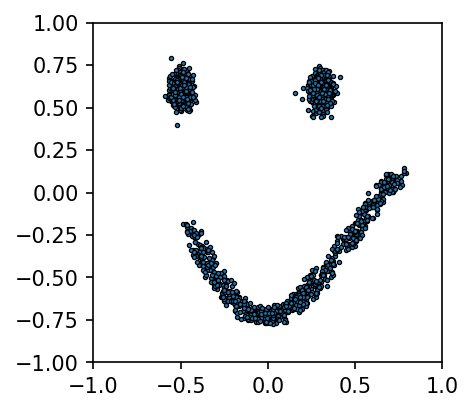

In [1434]:
n_points = 700

x =np.linspace(-0.7,0.6,400)

def y(x):
    return 0.22-0.5*(x+0.7)-0.7*np.sin((x+0.7)/0.35)

signal_points = -0.5+1.2*np.random.rand(n_points)
signal_points = np.column_stack([signal_points+0.1*np.random.rand(n_points), 
                                 y(signal_points)+0.1*np.random.rand(n_points) ])

signal_points = np.concatenate([signal_points, 
                                 np.column_stack(
                                     [-0.5+0.03*np.random.normal(size=(n_points)),
                                      0.6+0.05*np.random.normal(size=(n_points))])
                            ])

signal_points = np.concatenate([signal_points, 
                                 np.column_stack(
                                     [0.3+0.03*np.random.normal(size=(n_points)),
                                      0.6+0.05*np.random.normal(size=(n_points))])
                            ])


signal_points = signal_points[ (signal_points[:,0] >= -1) & (signal_points[:,0] <= 1)
                              & (signal_points[:,1] >= -1) & (signal_points[:,1] <= 1)
                             ]


fig,ax = plt.subplots(figsize=(3,3),dpi=150)

ax.scatter(signal_points[:,0],signal_points[:,1],s=4,ec='k',linewidth=0.6)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

## this is like a picture of a cat or a person being points in the space of $N\times M \times 3$ color images

torch.Size([3, 281, 300])


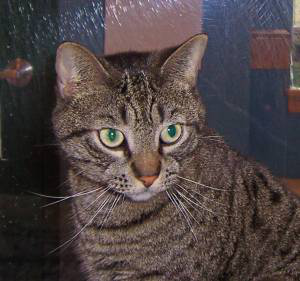

In [1435]:
img = Image.open('cat_image.jpg')
print(transforms.ToTensor()(img).shape)
img

## in the space of all 281x300x3 images, cat images come from an unknown $P(X)$


### given a dataset of cat pictures - we have a sample of those, just like the 2D points above

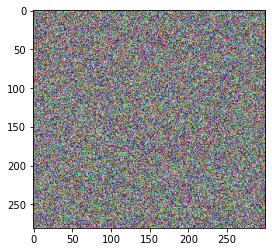

In [4]:
plt.imshow( np.random.rand(281,300,3) )

## we want to train a model, that generates points from $P(X)$,
## but not only the points we have in our dataset - we want it to generalize

## Lets create a generator - it will be a function from $\mathbb{R}^2$ to $\mathbb{R}^2$

In [1327]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0,0.5)
        

class Generator(nn.Module):
    def __init__(self,layer_sizes,inputsize=2,outputsize=2):
        super(Generator,self).__init__()
        
        
        self.layers = nn.ModuleList()
        
        
        self.layer1 = nn.Linear(inputsize,layer_sizes[0])
        for hidden_i in range(1,len(layer_sizes)):
            self.layers.append(nn.Linear(layer_sizes[hidden_i-1],layer_sizes[hidden_i]))
        self.layer2 = nn.Linear(layer_sizes[-1],outputsize)
        self.activation = nn.ReLU()
        
        
    
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation(out)
        
        for layer in self.layers:
            out = layer(out)
            out = self.activation(out)
            
        out =   self.layer2(out) 
        
        return out


        

In [1328]:
gen = Generator([20]*10,inputsize=2,outputsize=2)
gen.apply(weights_init);

In [1329]:
gen(torch.FloatTensor([-0.3,0])).data.numpy()

array([27.99629 , 62.971012], dtype=float32)

## so now our generator maps from points in 2D latent space to points in the 2D space of our data
## our generation procedure is to sample points from N(0,1) in the 2D space, and then pass them through the network - this defines $\tilde{P}(X)$

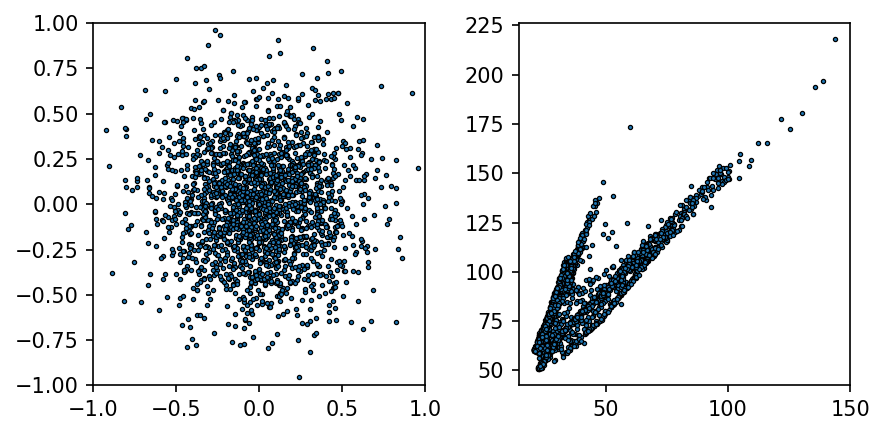

In [1330]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

xs = np.random.normal(loc=0,scale=0.3,size=(2000,2))

points = gen(torch.FloatTensor(xs)).data.numpy()


ax[0].scatter(xs[:,0],xs[:,1],s=4,ec='k',linewidth=0.6)

ax[1].scatter(points[:,0],points[:,1],s=4,ec='k',linewidth=0.6)

ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)


plt.tight_layout()
plt.show()

## How do we train our $\tilde{P}(X)$ to match the unknown $P(X)$ of the data points?

## we train a classifier to tell apart the data points from points that are uniform in the 2D space

(-1.0, 1.0)

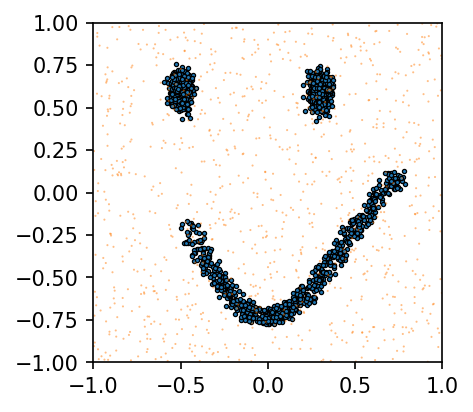

In [1331]:
n_bkg_points = 1000
bkg_points = np.column_stack([-1+2*np.random.rand(n_bkg_points),-1+2*np.random.rand(n_bkg_points)])


X = torch.FloatTensor( np.concatenate((signal_points,bkg_points)) )
Y = torch.FloatTensor( np.concatenate( ( np.ones(len(signal_points)), np.zeros(len(bkg_points)) )) ).unsqueeze(1)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset,batch_size=100)


fig,ax = plt.subplots(figsize=(3,3),dpi=150)

ax.scatter(signal_points[:,0],signal_points[:,1],s=4,ec='k',linewidth=0.6)
ax.scatter(bkg_points[:,0],bkg_points[:,1],s=1,ec='none',alpha=0.5)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

In [1332]:
Y.shape

torch.Size([3100, 1])

In [1333]:
class Classifier(nn.Module):
    def __init__(self,layer_sizes,dropout_p=-1):
        super(Classifier,self).__init__()
        
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        
        
        self.layer1 = nn.Linear(2,layer_sizes[0])
        for hidden_i in range(1,len(layer_sizes)):
            self.layers.append(nn.Linear(layer_sizes[hidden_i-1],layer_sizes[hidden_i]))
        self.layer2 = nn.Linear(layer_sizes[-1],1)
        self.activation = nn.ReLU()
        if self.dropout_p > 0: 
            self.dropout = nn.Dropout(dropout_p)
    
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation(out)
        if self.dropout_p > 0: 
            out = self.dropout(out)
        for layer in self.layers:
            out = layer(out)
            out = self.activation(out)
            if self.dropout_p > 0: 
                out = self.dropout(out)
        out =   self.layer2(out) 
        return out

In [1334]:
classifier = Classifier([256]*10,0.2)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1.2*1e-4)

In [1335]:


def train_one_epoch(nn,optimizer):
    
    nn.train()
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = nn(x)
        loss = loss_func(output,y)
        
        
        
        loss.backward()  
        optimizer.step()

n_epochs = 150

for epoch in tqdm( range(n_epochs) ):

    train_one_epoch(classifier,optimizer)

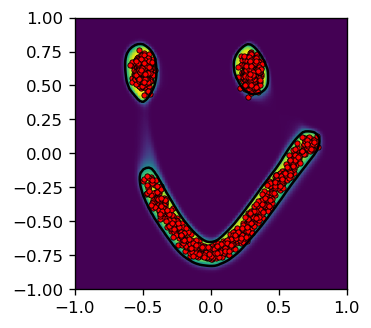

In [1336]:
fig,ax = plt.subplots(figsize=(3,3),dpi=120)


sigmoid = nn.Sigmoid()

grid_resolution = 100
x1,x2 = np.meshgrid(np.linspace(-1,1,grid_resolution),np.linspace(-1,1,grid_resolution))

x1 = x1.reshape(-1)
x2 = x2.reshape(-1)
inputs = torch.FloatTensor( np.column_stack((x1,x2)) )

x1,x2 = np.meshgrid(np.linspace(-1,1,grid_resolution),np.linspace(-1,1,grid_resolution))

def get_net_pred(nn):
    nn.eval()
    prediction = nn(inputs)
    net_prediction = sigmoid(prediction).data.numpy().reshape(grid_resolution,grid_resolution)
    
    return net_prediction


ax.imshow(get_net_pred(classifier),extent=(-1,1,-1,1),origin='lower')
ax.contour(x1,x2,get_net_pred(classifier),[0.5],colors='k',extent=(-1,1,-1,1),origin='lower')
ax.scatter(signal_points[:,0],signal_points[:,1],s=10,c='red',ec='k',linewidth=0.5)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

plt.show()

In [1337]:
torch.save(classifier.state_dict(),'classifier.pt')

In [1338]:
classifier.load_state_dict(torch.load('classifier.pt'))

<All keys matched successfully>

## Now we can train our generator, with the classifier serving as a loss function

In [1339]:
gen = Generator([80,30,20,10],inputsize=2,outputsize=2)
gen.apply(weights_init);

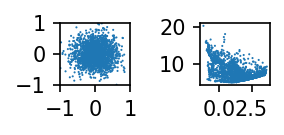

In [1340]:
fig,ax = plt.subplots(1,2,figsize=(2,1),dpi=150)

xs = np.random.normal(loc=0,scale=0.3,size=(2000,2))

points = gen(torch.FloatTensor(xs)).data.numpy()


ax[0].scatter(xs[:,0],xs[:,1],s=1,ec='none',linewidth=0.6)

ax[1].scatter(points[:,0],points[:,1],s=1,ec='none',linewidth=0.6)

ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)


plt.tight_layout()
plt.show()

In [1341]:
loss_func = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(gen.parameters(), lr=1e-3)


batch_size = 250

gen.train()

losses = []

for batch in tqdm( range(2000) ):
    optimizer.zero_grad()
    random_z = np.random.normal(loc=0,scale=0.3,size=(batch_size,2))
    generated_x = gen(torch.FloatTensor(random_z))
    
    loss = loss_func(classifier(generated_x),torch.ones(size=(batch_size,1)))
    losses.append(loss.item())
    loss.backward()  
    optimizer.step()

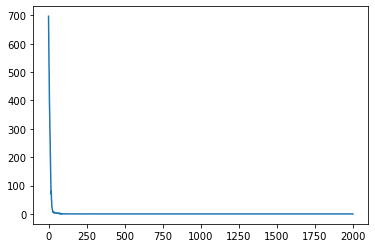

In [1342]:
plt.plot(losses)

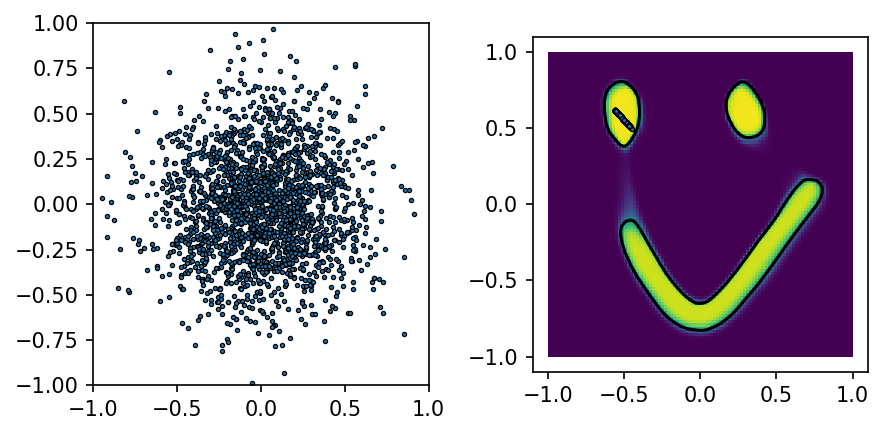

In [1343]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

xs = np.random.normal(loc=0,scale=0.3,size=(2000,2))

gen.eval()
points = gen(torch.FloatTensor(xs)).data.numpy()


ax[0].scatter(xs[:,0],xs[:,1],s=4,ec='k',linewidth=0.6)

ax[1].scatter(points[:,0],points[:,1],s=4,ec='k',linewidth=0.6)

ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)

ax[1].set_xlim(-1.1,1.1)
ax[1].set_ylim(-1.1,1.1)


sigmoid = nn.Sigmoid()

grid_resolution = 100
x1,x2 = np.meshgrid(np.linspace(-1,1,grid_resolution),np.linspace(-1,1,grid_resolution))

x1 = x1.reshape(-1)
x2 = x2.reshape(-1)
inputs = torch.FloatTensor( np.column_stack((x1,x2)) )

x1,x2 = np.meshgrid(np.linspace(-1,1,grid_resolution),np.linspace(-1,1,grid_resolution))

ax[1].imshow(get_net_pred(classifier),extent=(-1,1,-1,1),origin='lower',vmin=0,vmax=1)
ax[1].contour(x1,x2,get_net_pred(classifier),[0.5],colors='k',extent=(-1,1,-1,1),origin='lower')



plt.tight_layout()
plt.show()

## lets train the classifier and generator together!

![GAN](https://casser.io/files/pictures/gan_schema.png)

from https://deeplearning4j.org/

In [1417]:
classifier = Classifier([256]*10)


gen = Generator([80,30,20,10],inputsize=2,outputsize=2)
gen.apply(weights_init);

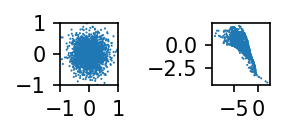

In [1418]:
fig,ax = plt.subplots(1,2,figsize=(2,1),dpi=150)

xs = np.random.normal(loc=0,scale=0.3,size=(2000,2))

points = gen(torch.FloatTensor(xs)).data.numpy()


ax[0].scatter(xs[:,0],xs[:,1],s=1,ec='none',linewidth=0.6)

ax[1].scatter(points[:,0],points[:,1],s=1,ec='none',linewidth=0.6)

ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
#ax[1].set_xlim(-1,1)
#ax[1].set_ylim(-1,1)

plt.tight_layout()
plt.show()

In [1419]:
mkdir models

mkdir: models: File exists


In [1420]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
gen_optimizer = optim.Adam(gen.parameters(), lr=1e-3)

X = torch.FloatTensor( signal_points )
Y = torch.FloatTensor( np.ones(len(signal_points)) ).unsqueeze(1)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset,batch_size=300)

alternate_every = 2
n_epochs = 2000

batch_count = 0

training_the = 'classifier'
classifier.train()
gen.eval()


classifier_loss = []
generator_loss = []

min_generator_loss = 1

for epoch in tqdm( range(n_epochs) ):
    
    
    if epoch % 10==0:
        torch.save(classifier.state_dict(),'models/classifier_'+str(epoch)+'.pt')
        torch.save(gen.state_dict(),'models/generator_'+str(epoch)+'.pt')
    for x,y in dataloader:
        
        batch_count+=1
        if batch_count % alternate_every == 0:
            if training_the=='classifier':
                training_the = 'generator'
                classifier.eval()
                gen.train()
            else:
                training_the='classifier'
                classifier.train()
                gen.eval()

             
        optimizer.zero_grad()
        gen_optimizer.zero_grad()

        batch_size, _ = x.shape
        random_z = np.random.normal(size=(batch_size,2))
        generated_x = gen(torch.FloatTensor(random_z))

        x_batch = torch.cat([x,generated_x],dim=0)
        y_batch = torch.cat([y,torch.zeros(y.shape)],dim=0)

        class_prediction = classifier(x_batch)

        
        
        if training_the=='classifier':
            loss = loss_func(class_prediction,y_batch)
            
            classifier_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
        else:
            loss = loss_func(classifier(generated_x),torch.ones(y.shape))
            
            generator_loss.append(loss.item())
            
            if loss.item() < min_generator_loss:
                torch.save(gen.state_dict(),'generator.pt')
            
            loss.backward()
            gen_optimizer.step()
    
            

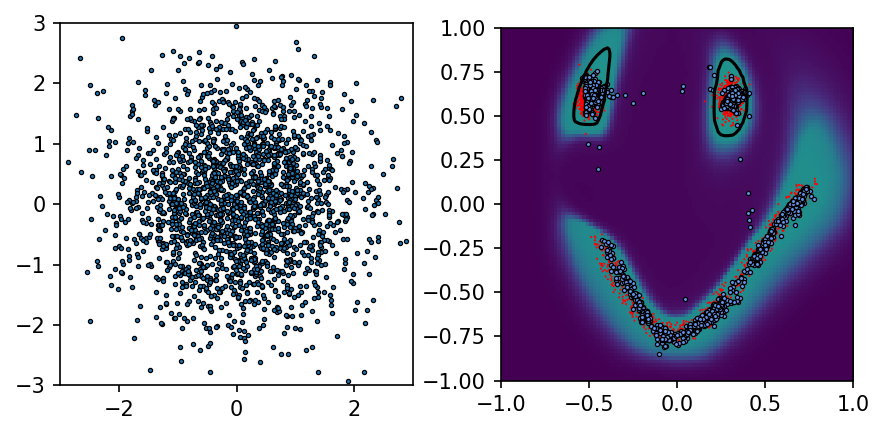

In [1442]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

xs = np.random.normal(size=(2000,2))

gen.eval()
points = gen(torch.FloatTensor(xs)).data.numpy()


ax[0].scatter(xs[:,0],xs[:,1],s=4,ec='k',linewidth=0.6)

ax[1].scatter(signal_points[:,0],signal_points[:,1],fc='r',s=1,ec='none',linewidth=0.6)
ax[1].scatter(points[:,0],points[:,1],fc='cornflowerblue',s=4,ec='k',linewidth=0.6)


ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)

ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)


sigmoid = nn.Sigmoid()

grid_resolution = 100
x1,x2 = np.meshgrid(np.linspace(-1,1,grid_resolution),np.linspace(-1,1,grid_resolution))

x1 = x1.reshape(-1)
x2 = x2.reshape(-1)
inputs = torch.FloatTensor( np.column_stack((x1,x2)) )

x1,x2 = np.meshgrid(np.linspace(-1,1,grid_resolution),np.linspace(-1,1,grid_resolution))

def get_net_pred(nn):
    nn.eval()
    prediction = nn(inputs)
    net_prediction = sigmoid(prediction).data.numpy().reshape(grid_resolution,grid_resolution)
    
    return net_prediction

ax[1].imshow(get_net_pred(classifier),extent=(-1,1,-1,1),origin='lower',vmin=0,vmax=1)
ax[1].contour(x1,x2,get_net_pred(classifier),[0.5],colors='k',extent=(-1,1,-1,1),origin='lower')



plt.tight_layout()
plt.show()

In [1436]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider

In [1441]:
def generate_img(epoch):
    fig,ax = plt.subplots(figsize=(5,5))
    classifier.load_state_dict(torch.load('models/classifier_'+str(epoch)+'.pt'))
    ax.imshow(get_net_pred(classifier),extent=(-1,1,-1,1),origin='lower',vmin=0,vmax=1)
    gen.load_state_dict(torch.load('models/generator_'+str(epoch)+'.pt'))
    xs = np.random.normal(size=(1000,2))

    gen.eval()
    points = gen(torch.FloatTensor(xs)).data.numpy()
    ax.scatter(points[:,0],points[:,1],fc='cornflowerblue',s=4,ec='k',linewidth=0.6)
    
    
    plt.show()

interactive_plot = interactive(generate_img, epoch=IntSlider(min=0, max=1990, step=10, continuous_update=False)
                               )
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='epoch', max=1990, step=10), Out…